In [1]:
import numpy as np
from gwbench import snr
from gwbench import waveform as wfc
from gwbench import injections
from gwbench import network
from gwbench import basic_relations as br
# from gwbench.snr import scalar_product_freq_array

import time

from pycbc import conversions as conv

from astropy.cosmology import Planck18, z_at_value

import gwbench_network_funcs as gwnet

from scipy.optimize import minimize
from scipy import optimize
from scipy import interpolate
from scipy import integrate

import lalsimulation as ls
import lal

from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.filter import matchedfilter
import pycbc.filter as fil

from pycbc import types, fft, waveform


In [2]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 18
})

%config InlineBackend.figure_format='retina' # very useful command for high-res images


In [3]:
def inner_prod_simps_normed(h1, h2, Sn, f, h1_norm = None, h2_norm=None):
    if h1_norm is None:
        h1_norm = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn, x=f))
    if h2_norm is None:
        h2_norm = 4*np.real(integrate.simpson(y= h2*np.conjugate(h2) / Sn, x=f))
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f)) / (np.sqrt(h1_norm * h2_norm))

def inner_prod_simps(h1, h2, Sn, f):
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f))

def cutler_vallisneri_overlap_vec(del_hf, delta_hf, psd, freqs):
    return np.array([ inner_prod_simps(del_hf[deriv], delta_hf, psd, freqs) for deriv in del_hf ])

In [5]:
input_file = 'smooth_powerlaw_pop.npz'
with np.load(input_file, mmap_mode='r') as binaries:
    Mcs = np.array(binaries['Mcs'])
    etas = np.array(binaries['etas'])
    chi1z = np.array(binaries['chi1z'])
    chi2z = np.array(binaries['chi2z'])
    DLs = np.array(binaries['DLs'])
    iotas = np.array(binaries['iotas'])
    ras = np.array(binaries['ras'])
    decs = np.array(binaries['decs'])
    psis = np.array(binaries['psis'])

In [4]:
index_golden = 54837
index_typical = 21985
index_optimistic = 78736
index_pessimistic = 47519

index_mass_gap = 73505

In [6]:
i = index_typical

network_spec = ['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

inj_params = {
    'Mc':    Mcs[i],
    'eta':   etas[i],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[i],
    'chi2z': chi2z[i],
    'DL':    DLs[i],
    'tc':    0.,
    'phic':  0.,
    'iota':  iotas[i],
    'ra':    ras[i],
    'dec':   decs[i],
    'psi':   psis[i],
    # 'gmst0': bilby.gw.utils.greenwich_mean_sidereal_time(0.),
    'gmst0': 0., 
    'fRef': 5.0
} 

d_f = 2**-4
f_low = 5.
f_high = 2048.
f = np.arange(f_low, f_high, d_f)
 
deriv_symbs_string = 'Mc eta DL chi1z chi2z tc phic iota ra dec psi'
deriv_variables = ['Mc', 'eta', 'DL', 'chi1z', 'chi2z', 'tc', 'phic', 'iota', 'ra', 'dec', 'psi']

In [7]:
net_ap = network.Network(network_spec=network_spec)

approximant = 'IMRPhenomD'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_ap.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant, 'fRef':inj_params['fRef']})


use_rot = 0

net_ap.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    use_rot=use_rot
    )
net_ap.calc_wf_polarizations()
net_ap.calc_wf_polarizations_derivs_num(step=1e-9, method='central', order=2, n=1)
net_ap.setup_ant_pat_lpf_psds()
net_ap.calc_det_responses()
net_ap.calc_det_responses_derivs_num(step=1e-9, method='central', order=2, n=1)
net_ap.calc_snrs()
net_ap.calc_errors()


net_tr = network.Network(network_spec=network_spec)

approximant = 'IMRPhenomXAS'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_tr.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant, 'fRef': inj_params['fRef']})

net_tr.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    use_rot=use_rot
    )
net_tr.calc_wf_polarizations()
net_tr.setup_ant_pat_lpf_psds()
net_tr.calc_det_responses()
net_tr.calc_snrs()

2024-01-15 16:22:50,935 - Network - INFO : Polarizations calculated.
2024-01-15 16:22:50,936 - Network - INFO : Calculate numeric derivatives of polarizations.
2024-01-15 16:22:50,943 - Network - INFO : Polarizations calculated.
2024-01-15 16:23:02,144 - Network - INFO : Numeric derivatives of polarizations calculated.
2024-01-15 16:23:02,531 - Network - INFO : PSDs loaded.
2024-01-15 16:23:02,543 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-15 16:23:02,607 - Network - INFO : Detector responses calculated.
2024-01-15 16:23:02,609 - Network - INFO : Calculate numeric derivatives of detector responses.
2024-01-15 16:23:02,609 - Network - INFO :    CE-40_C
2024-01-15 16:23:10,001 - Network - INFO :    CE-20_S
2024-01-15 16:23:15,059 - Network - INFO :    ET_ET1
2024-01-15 16:23:20,759 - Network - INFO :    ET_ET2
2024-01-15 16:23:26,935 - Network - INFO :    ET_ET3
2024-01-15 16:23:33,220 - Network - INFO : Numeric derivatives of detector responses calculated.
2024-01-15 1

In [13]:
d = 0
h1 = net_tr.detectors[d].hf
h2 = net_ap.detectors[d].hf
f = net_ap.detectors[d].f
Sn = net_ap.detectors[d].psd
network_spec_d = [net_ap.detectors[d].det_key]

time_arr_d = np.linspace(0., 0.6, 1001)
x_t0_re_d = np.zeros(len(time_arr_d))
x_t0_im_d = np.zeros(len(time_arr_d))

for i in range(len(time_arr_d)):
    t0 = time_arr_d[i]
    x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
    x_t0_re_d[i] = np.real(x_t0_d)
    x_t0_im_d[i] = np.imag(x_t0_d)

max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
time_shift_d = time_arr_d[max_idx]
phase_shift_d = np.angle(x_t0_re_d + 1j*x_t0_im_d)[max_idx]

print("time shift:", time_shift_d)
print("phase shift:", phase_shift_d)

inj_params_opt_d = inj_params.copy()
inj_params_opt_d['tc'] = time_shift_d # should be positive when shifting XAS to maximize overlap
inj_params_opt_d['phic'] = phase_shift_d  # should be negative when shifting XAS to maximize overlap

net_tr_opt_d = network.Network(network_spec=network_spec_d)
net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS', 'fRef': inj_params['fRef']})
net_tr_opt_d.set_net_vars(
    f=f, inj_params=inj_params_opt_d,
    deriv_symbs_string=deriv_symbs_string,
    use_rot=use_rot
    )
net_tr_opt_d.calc_wf_polarizations()
net_tr_opt_d.setup_ant_pat_lpf_psds()
net_tr_opt_d.calc_det_responses()
net_tr_opt_d.calc_wf_polarizations()

h1_opt = net_tr_opt_d.detectors[0].hf


inj_params_opt_d = inj_params.copy()
inj_params_opt_d['tc'] = -time_shift_d # should be positive when shifting XAS to maximize overlap
inj_params_opt_d['phic'] = -phase_shift_d  # should be negative when shifting XAS to maximize overlap

net_ap_opt_d = network.Network(network_spec=network_spec_d)
net_ap_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomD', 'fRef': inj_params['fRef']})
net_ap_opt_d.set_net_vars(
    f=f, inj_params=inj_params_opt_d,
    deriv_symbs_string=deriv_symbs_string,
    use_rot=use_rot
    )
net_ap_opt_d.calc_wf_polarizations()
net_ap_opt_d.setup_ant_pat_lpf_psds()
net_ap_opt_d.calc_det_responses()
net_ap_opt_d.calc_wf_polarizations()

h2_opt = net_ap_opt_d.detectors[0].hf

print()

print("Inner product before aligning:")
print(np.abs(inner_prod_simps_normed(h1, h2, net_ap.detectors[d].psd, net_ap.detectors[d].f)))
print()
print("Inner product after aligning:")
print(np.abs(inner_prod_simps_normed(h1, h2_opt, net_ap.detectors[d].psd, net_ap.detectors[d].f)))


2024-01-15 16:27:22,646 - Network - INFO : Polarizations calculated.
2024-01-15 16:27:22,656 - Network - INFO : PSDs loaded.
2024-01-15 16:27:22,658 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-15 16:27:22,667 - Network - INFO : Detector responses calculated.
2024-01-15 16:27:22,674 - Network - INFO : Polarizations calculated.
2024-01-15 16:27:22,681 - Network - INFO : Polarizations calculated.
2024-01-15 16:27:22,688 - Network - INFO : PSDs loaded.
2024-01-15 16:27:22,690 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-15 16:27:22,696 - Network - INFO : Detector responses calculated.
2024-01-15 16:27:22,702 - Network - INFO : Polarizations calculated.


time shift: 0.0012
phase shift: -2.374609041664043

Inner product before aligning:
0.8145320375743167

Inner product after aligning:
0.9982315663448789


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


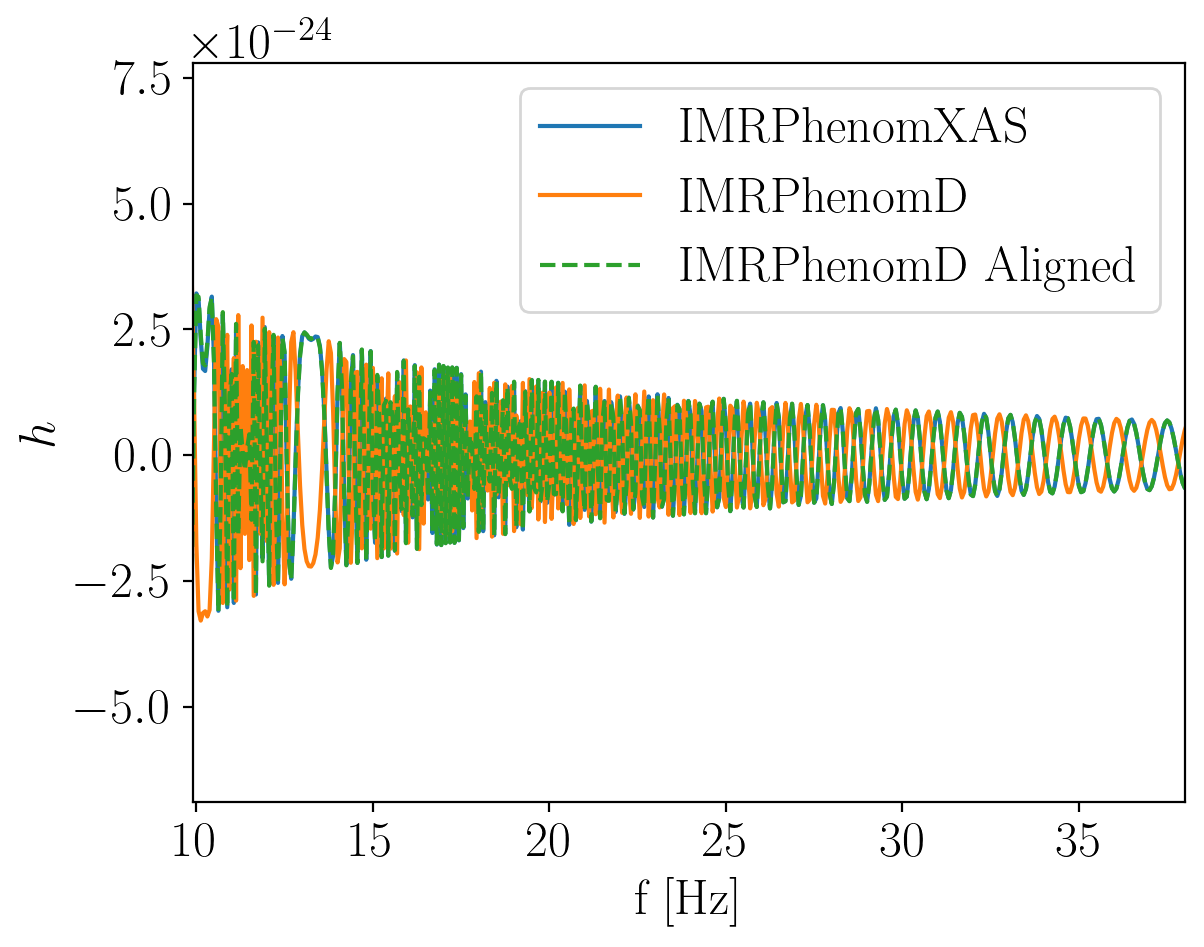

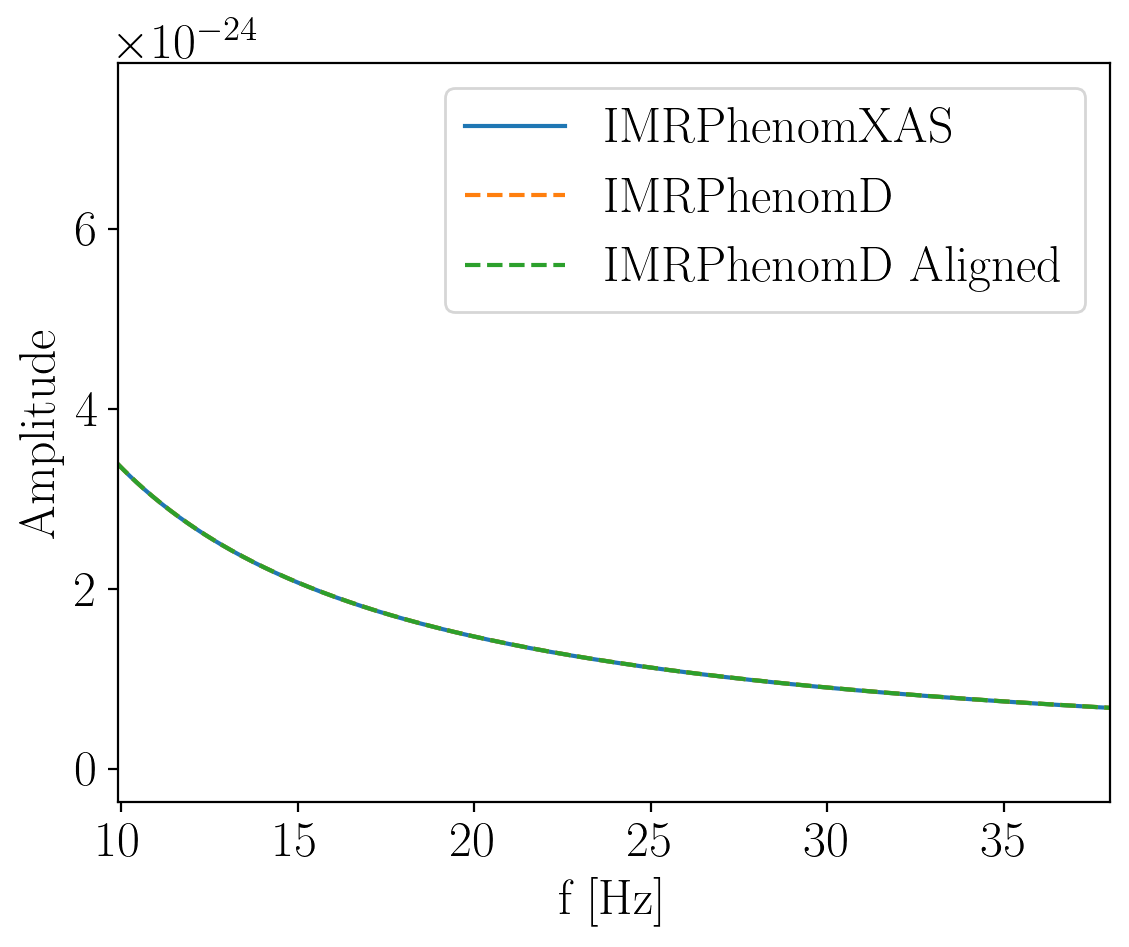

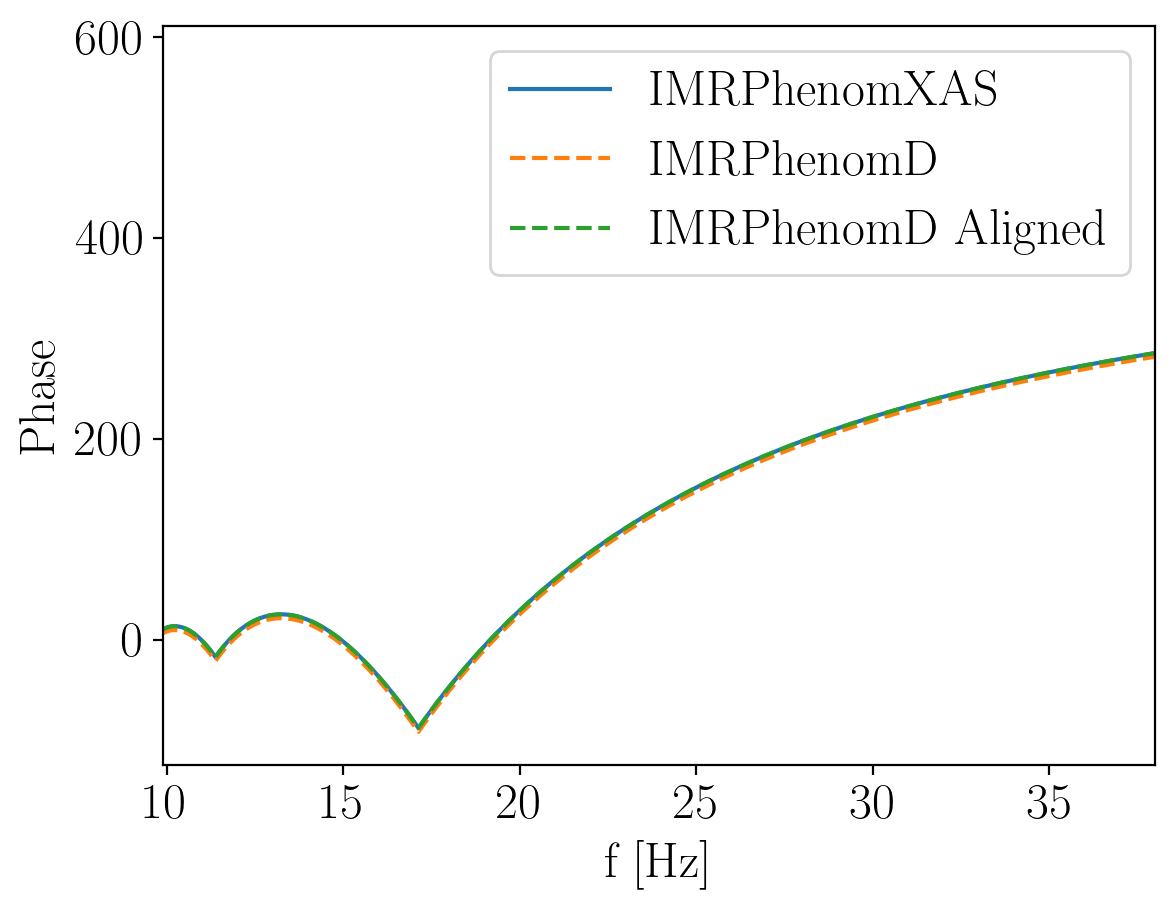

In [14]:
plt.plot(f, h1, label='IMRPhenomXAS')
plt.plot(f, h2, label='IMRPhenomD')
plt.plot(f, h2_opt,  ls='--', label='IMRPhenomD Aligned')
plt.xlabel('f [Hz]')
plt.ylabel('$h$')
plt.legend()
plt.xlim(9.9, 38)
plt.show()

# Amplitude
plt.plot(f, np.abs(h1), label='IMRPhenomXAS')
plt.plot(f, np.abs(h2), ls='--', label='IMRPhenomD')
plt.plot(f, np.abs(h2_opt),  ls='--', label='IMRPhenomD Aligned')
plt.xlabel('f [Hz]')
plt.ylabel('Amplitude')
plt.legend()
plt.xlim(9.9, 38)
plt.show()

# Phase
plt.plot(f, np.unwrap(np.angle(h1)), label='IMRPhenomXAS')
plt.plot(f, np.unwrap(np.angle(h2)), ls='--', label='IMRPhenomD')
plt.plot(f, np.unwrap(np.angle(h2_opt)),  ls='--', label='IMRPhenomD Aligned')
plt.xlabel('f [Hz]')
plt.ylabel('Phase')
plt.legend()
plt.xlim(9.9, 38)
plt.show()

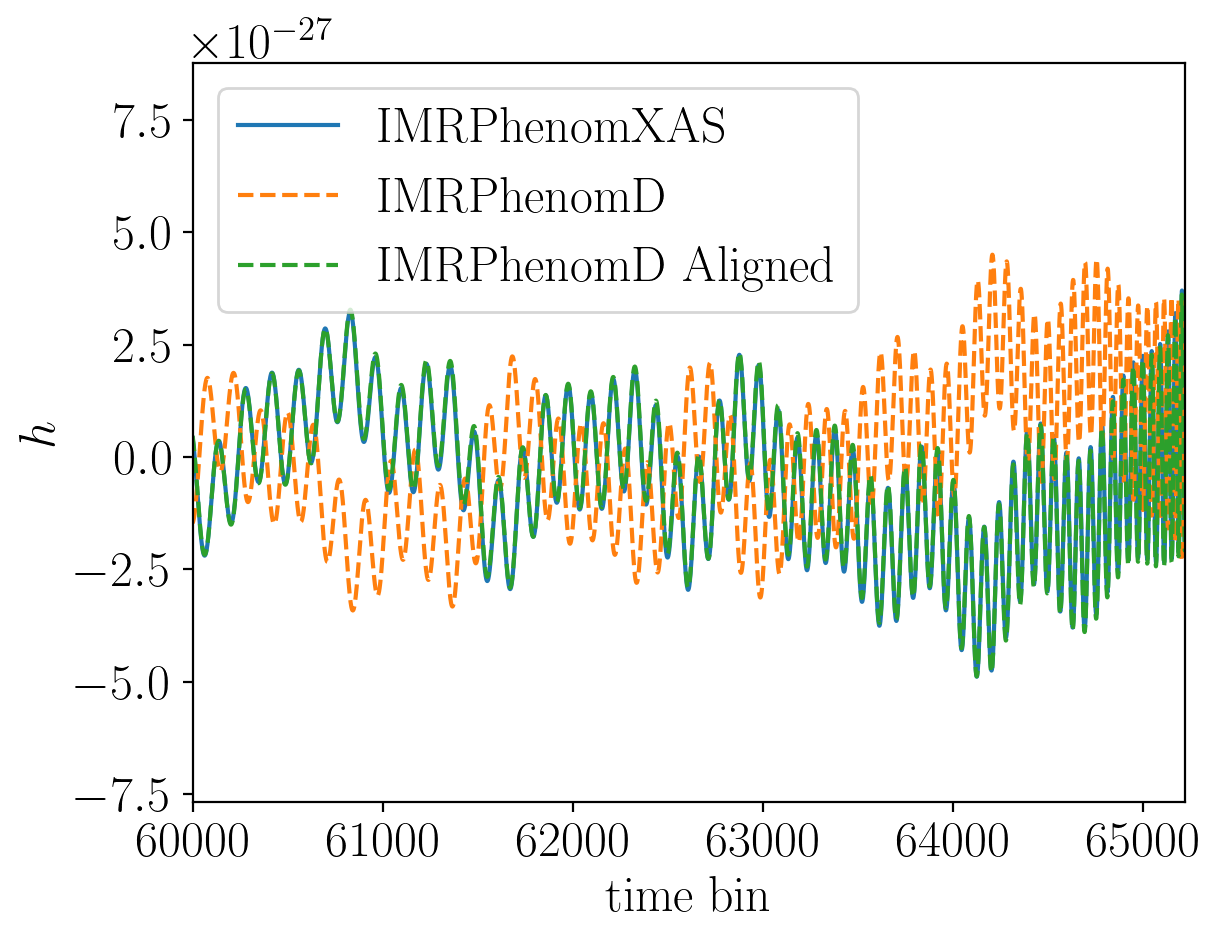

In [17]:
# Time Domain
plt.plot(np.fft.irfft(h1), label='IMRPhenomXAS')
plt.plot(np.fft.irfft(h2), ls='--', label='IMRPhenomD')
plt.plot(np.fft.irfft(h2_opt),  ls='--', label='IMRPhenomD Aligned')
plt.xlabel('time bin')
plt.ylabel('$h$')
plt.legend()
plt.xlim(60000, 65220)
plt.show()

# DL Bias vs Phase Shift

In [18]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))


phis = np.linspace(-np.pi, 0.0, 50)
DL_biases = np.zeros(len(phis))
overlaps = np.zeros(len(phis))

for i in range(len(phis)):
    for d in range(len(net_ap.detectors)):
        ## set up initial waveforms
        h1 = net_tr.detectors[d].hf
        h2 = net_ap.detectors[d].hf
        f = net_ap.detectors[d].f
        Sn = net_ap.detectors[d].psd
        network_spec_d = [net_ap.detectors[d].det_key]

        phase_shift_test = phis[i]


        inj_params_opt_d = inj_params.copy()
        inj_params_opt_d['tc'] = time_shift_d # should be positive when shifting XAS to maximize overlap
        inj_params_opt_d['phic'] = phase_shift_test  # should be positive when shifting XAS to maximize overlap

        net_tr_opt_d = network.Network(network_spec=network_spec_d)
        net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS', 'fRef':inj_params['fRef']})
        net_tr_opt_d.set_net_vars(
            f=f, inj_params=inj_params_opt_d,
            deriv_symbs_string=deriv_symbs_string,
            use_rot=use_rot
            )
        net_tr_opt_d.calc_wf_polarizations()
        net_tr_opt_d.setup_ant_pat_lpf_psds()
        net_tr_opt_d.calc_det_responses()
        net_tr_opt_d.calc_wf_polarizations()


    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)

    cv_bias_opt = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
    cv_bias_opt = np.array(cv_bias_opt.tolist()[0])
    DL_biases[i] = cv_bias_opt[2]
    overlaps[i] = inner_prod_simps_normed(net_ap.detectors[d].hf, net_tr_opt_d.detectors[0].hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)



2024-01-15 16:29:47,473 - Network - INFO : Polarizations calculated.
2024-01-15 16:29:47,500 - Network - INFO : PSDs loaded.
2024-01-15 16:29:47,502 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-15 16:29:47,521 - Network - INFO : Detector responses calculated.
2024-01-15 16:29:47,526 - Network - INFO : Polarizations calculated.
2024-01-15 16:29:47,533 - Network - INFO : Polarizations calculated.
2024-01-15 16:29:47,540 - Network - INFO : PSDs loaded.
2024-01-15 16:29:47,541 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-15 16:29:47,548 - Network - INFO : Detector responses calculated.
2024-01-15 16:29:47,575 - Network - INFO : Polarizations calculated.
2024-01-15 16:29:47,586 - Network - INFO : Polarizations calculated.
2024-01-15 16:29:47,604 - Network - INFO : PSDs loaded.
2024-01-15 16:29:47,608 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-15 16:29:47,619 - Network - INFO : Detector responses calculated.
2024-01-15 16:29:47,630 - Network 

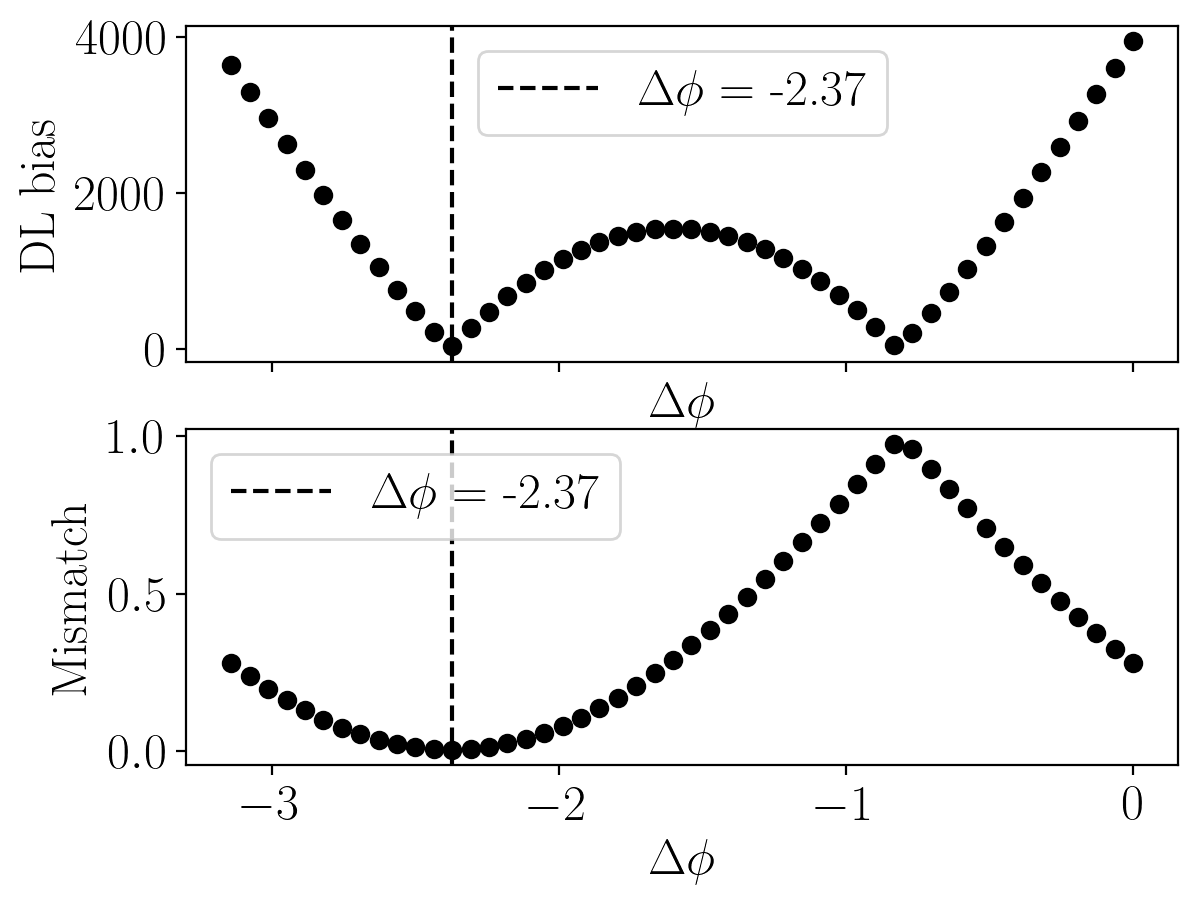

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].scatter(phis, np.abs(DL_biases))
ax[0].set_xlabel("$\Delta \phi$")
ax[0].set_ylabel("DL bias")
ax[0].axvline(x=phis[np.argmin(np.abs(DL_biases))], c='k', ls='--', label=f'$\Delta \phi$ = {phis[np.argmin(np.abs(DL_biases))]:.2f}')
ax[0].legend()

ax[1].scatter(phis, 1-np.abs(overlaps))
ax[1].set_xlabel("$\Delta \phi$")
ax[1].set_ylabel("Mismatch")
ax[1].axvline(x=phis[np.argmax(overlaps)], c='k', ls='--', label=f'$\Delta \phi$ = {phis[np.argmax(overlaps)]:.2f}')
ax[1].legend()
plt.show()

2024-01-15 17:09:21,554 - Network - INFO : Polarizations calculated.
2024-01-15 17:09:21,568 - Network - INFO : PSDs loaded.
2024-01-15 17:09:21,571 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-15 17:09:21,577 - Network - INFO : Detector responses calculated.
2024-01-15 17:09:21,583 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
2024-01-15 17:09:21,592 - Network - INFO : Polarizations calculated.
2024-01-15 17:09:21,605 - Network - INFO : PSDs loaded.
2024-01-15 17:09:21,607 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-15 17:09:21,613 - Network - INFO : Detector responses calculated.
2024-01-15 17:09:21,619 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning:

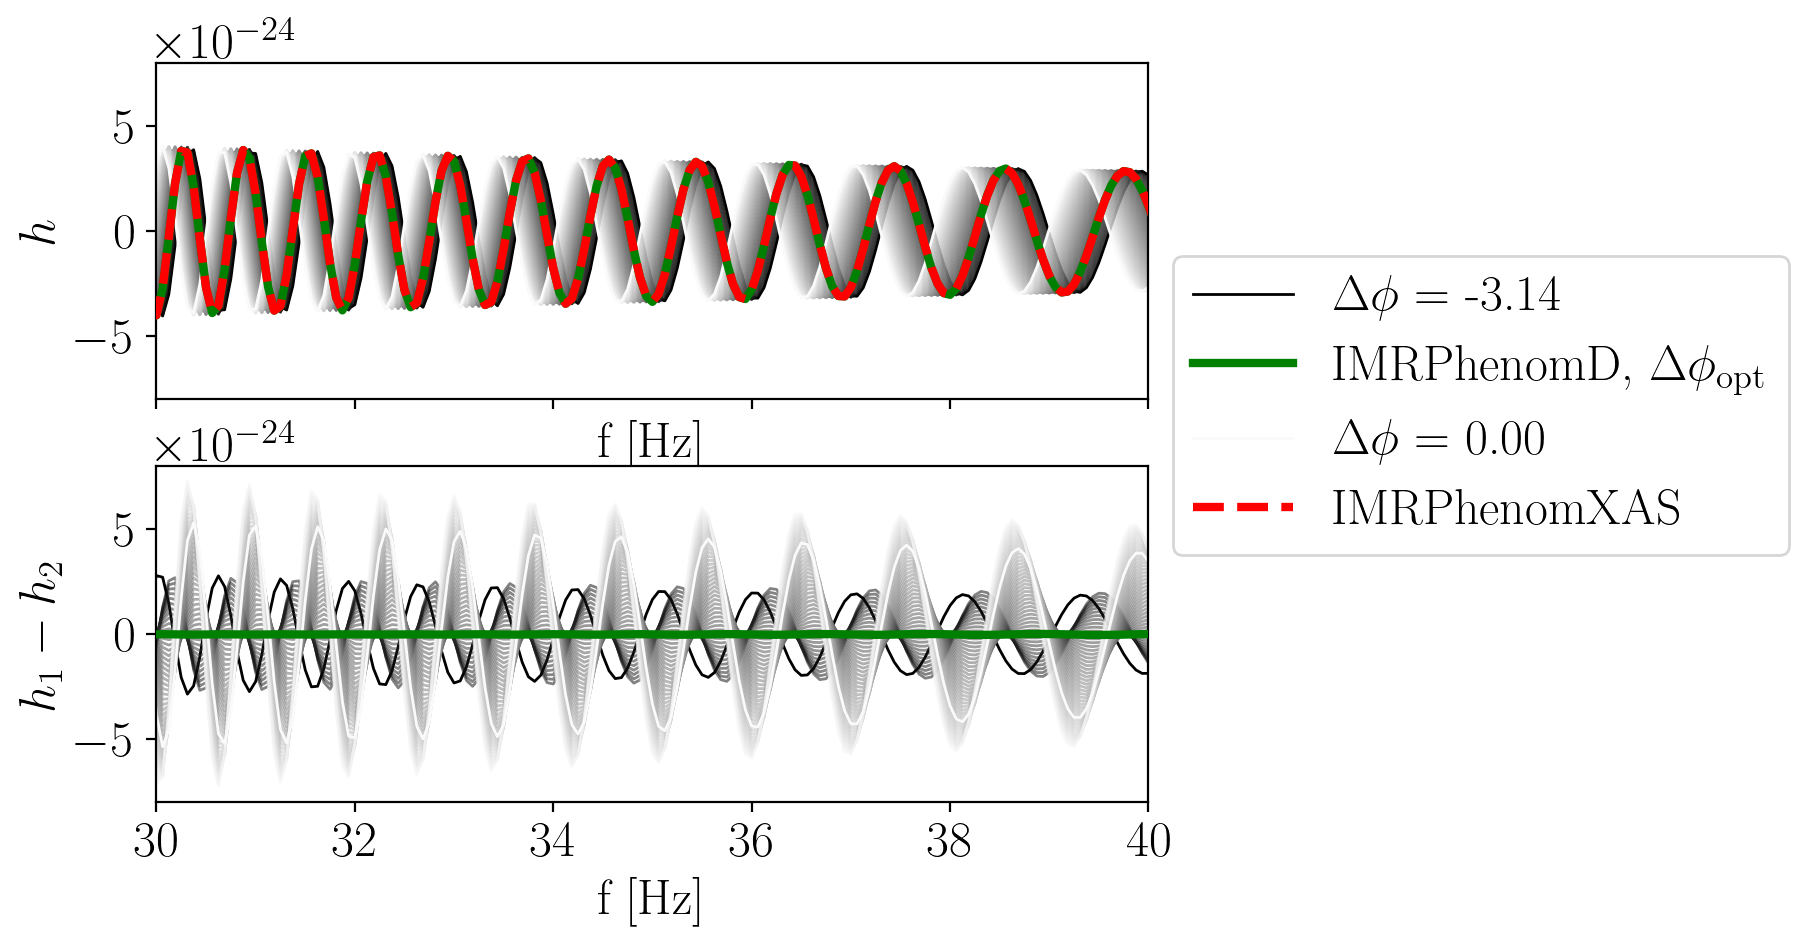

In [67]:
# Freq Domain
d=0
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

plt.rcParams["axes.prop_cycle"] = \
    plt.cycler("color", plt.cm.gray(np.linspace(0,1,len(phis))))

h11 = net_tr.hfp + 1j*net_tr.hfc

for i in range(len(phis)):
    phase_shift_test = phis[i]

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = -time_shift_d # should be positive when shifting XAS to maximize overlap
    inj_params_opt_d['phic'] = -phase_shift_test  # should be positive when shifting XAS to maximize overlap

    net_ap_opt_d = network.Network(network_spec=network_spec_d)
    net_ap_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomD', 'fRef': inj_params['fRef']})
    net_ap_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    net_ap_opt_d.calc_wf_polarizations()
    net_ap_opt_d.setup_ant_pat_lpf_psds()
    net_ap_opt_d.calc_det_responses()
    net_ap_opt_d.calc_wf_polarizations()
    h2_opt = net_ap_opt_d.hfp + 1j*net_ap_opt_d.hfc

    if (i==0 or i+1==len(phis)):
        ax[0].plot(f, h2_opt, lw=1, label=f'$\Delta \phi$ = {phase_shift_test:.2f}')
        ax[1].plot(f, h1-h2_opt, lw=1, label=f'$\Delta \phi$ = {phase_shift_test:.2f}')

    elif (i==np.argmax(overlaps)):
        ax[0].plot(f, h2_opt, lw=3, c='g', zorder=200, label='IMRPhenomD, $\Delta \phi_{\\rm opt}$')
        ax[1].plot(f, h11-h2_opt, lw=3, c='g', zorder=200, label='IMRPhenomD, $\Delta \phi_{\\rm opt}$')

    elif (i==np.argmin(DL_biases)):
        ax[0].plot(f, h2_opt, lw=3, c='b', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min DL Bias)')
        ax[1].plot(f, h11-h2_opt, lw=3, c='b', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min DL Bias)')
    else:
        ax[0].plot(f, h2_opt, lw=1, alpha=0.5)
        ax[1].plot(f, h11-h2_opt, lw=1, alpha=0.5)

ax[0].plot(f, h11, zorder=300, label='IMRPhenomXAS', c='r', ls='--', lw=3)
ax[0].set_xlabel('f [Hz]')
ax[0].set_ylabel('$h$')
ax[0].set_ylim(-8e-24, 8e-24)
ax[0].legend(bbox_to_anchor=(1,0.5))


ax[1].set_xlabel('f [Hz]')
ax[1].set_ylabel('$h_1 - h_2$')
ax[1].set_ylim(-8e-24, 8e-24)


plt.xlim(30, 40)

# plt.savefig('1D_bias_plots/DL_bias_vs_phic.pdf', dpi=300, bbox_inches='tight')
plt.show()

2024-01-15 16:41:29,967 - Network - INFO : Polarizations calculated.


2024-01-15 16:41:30,374 - Network - INFO : PSDs loaded.
2024-01-15 16:41:30,378 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-15 16:41:30,409 - Network - INFO : Detector responses calculated.
2024-01-15 16:41:30,442 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
2024-01-15 16:41:30,488 - Network - INFO : Polarizations calculated.
2024-01-15 16:41:30,516 - Network - INFO : PSDs loaded.
2024-01-15 16:41:30,520 - Network - INFO : Antenna patterns and LPFs loaded.
2024-01-15 16:41:30,530 - Network - INFO : Detector responses calculated.
2024-01-15 16:41:30,551 - Network - INFO : Polarizations calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return 

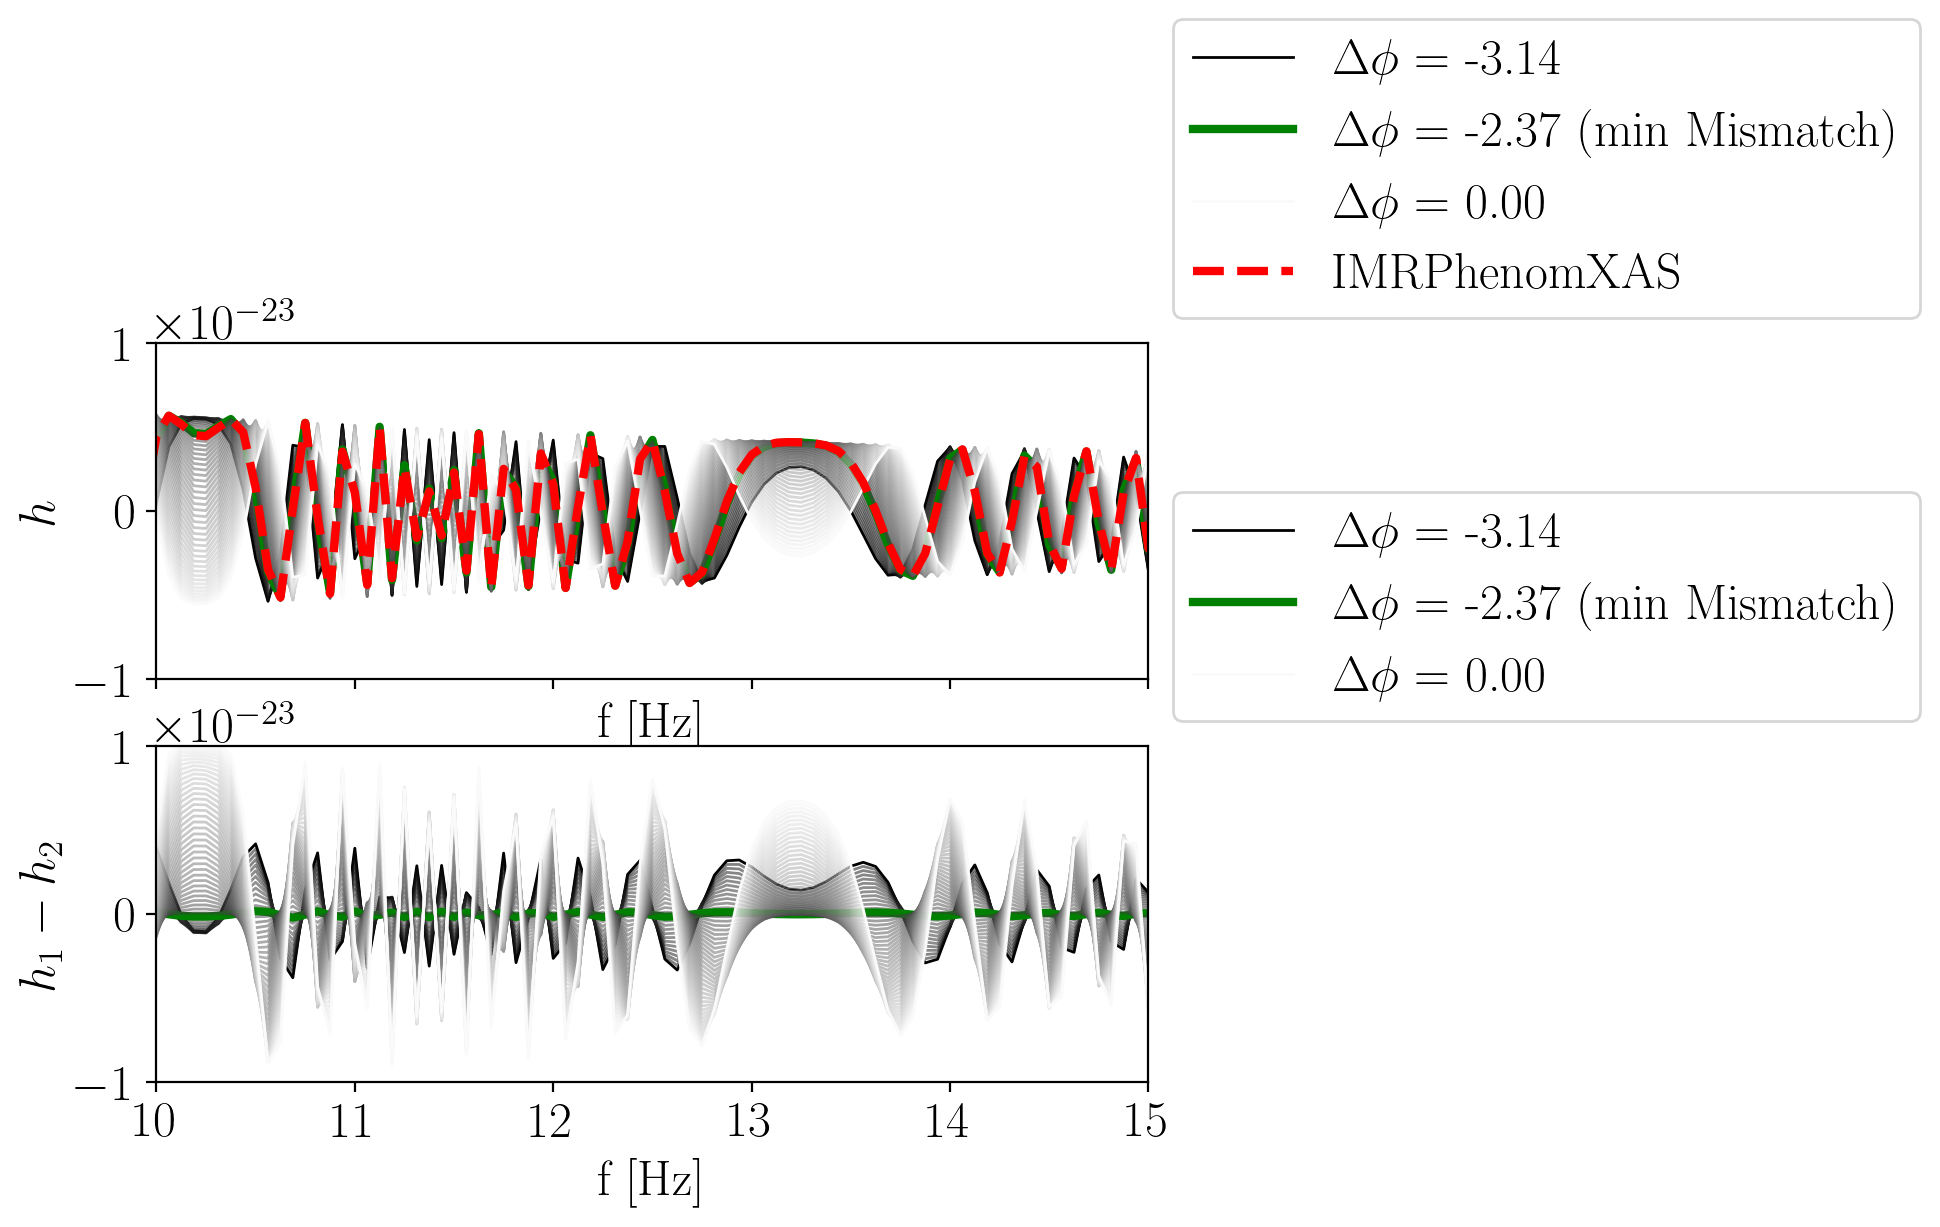

In [29]:
# Freq Domain, Detector Response
d=0
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

plt.rcParams["axes.prop_cycle"] = \
    plt.cycler("color", plt.cm.gray(np.linspace(0,1,len(phis))))

# h1 = net_tr.detectors[d].hf

for i in range(len(phis)):
    phase_shift_test = phis[i]

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = -time_shift_d # should be positive when shifting XAS to maximize overlap
    inj_params_opt_d['phic'] = -phase_shift_test  # should be positive when shifting XAS to maximize overlap

    net_tr_opt_d = network.Network(network_spec=network_spec_d)
    net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomD', 'fRef': inj_params['fRef']})
    net_tr_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    net_tr_opt_d.calc_wf_polarizations()
    net_tr_opt_d.setup_ant_pat_lpf_psds()
    net_tr_opt_d.calc_det_responses()
    net_tr_opt_d.calc_wf_polarizations()
    h2_opt = net_tr_opt_d.detectors[0].hf

    if (i==0 or i+1==len(phis)):
        ax[0].plot(f, h2_opt, lw=1, label=f'$\Delta \phi$ = {phase_shift_test:.2f}')
        ax[1].plot(f, h1-h2_opt, lw=1, label=f'$\Delta \phi$ = {phase_shift_test:.2f}')

    elif (i==np.argmax(overlaps)):
        ax[0].plot(f, h2_opt, lw=3, c='g', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min Mismatch)')
        ax[1].plot(f, h1-h2_opt, lw=3, c='g', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min Mismatch)')

    elif (i==np.argmin(DL_biases)):
        ax[0].plot(f, h2_opt, lw=3, c='b', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min DL Bias)')
        ax[1].plot(f, h1-h2_opt, lw=3, c='b', label=f'$\Delta \phi$ = {phase_shift_test:.2f} (min DL Bias)')
    else:
        ax[0].plot(f, h2_opt, lw=1, alpha=0.5)
        ax[1].plot(f, h1-h2_opt, lw=1, alpha=0.5)

ax[0].plot(f, h1, label='IMRPhenomXAS', c='r', ls='--', lw=3)
ax[0].set_xlabel('f [Hz]')
ax[0].set_ylabel('$h$')
ax[0].set_ylim(-1e-23, 1e-23)
ax[0].legend(bbox_to_anchor=(1,1))

ax[1].set_xlabel('f [Hz]')
ax[1].set_ylabel('$h_1 - h_2$')
ax[1].set_ylim(-1e-23, 1e-23)

ax[1].legend(bbox_to_anchor=(1,1))

plt.xlim(10., 15.)
plt.tight_layout
plt.show()

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


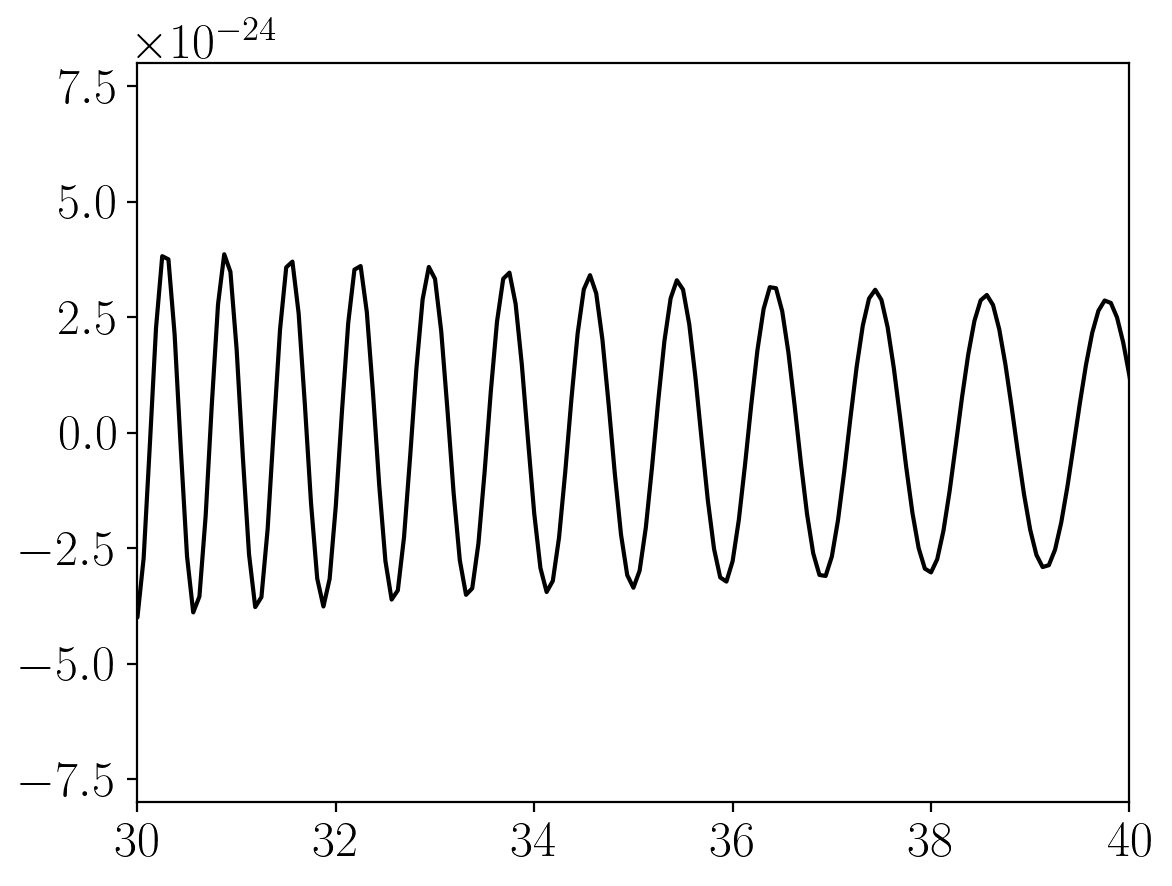

In [55]:
plt.plot(f, h11)
plt.xlim(30, 40)
plt.ylim(-8e-24, 8e-24)
plt.show()